# 多类支持向量机练习
在本练习中，您将：
-为SVM实现完全矢量化的**损失函数**
-实现其**解析梯度的完全矢量化表达式**
-**使用数值梯度检查您的实现**
-使用验证集**调整学习率和正则化**强度
-**使用**SGD优化**损失函数**
-**可视化**最终学习的权重

In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from dlcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import zipfile

# 指定要解压的ZIP文件名
zip_file = 'dlcv.zip'

# 指定解压后的目标文件夹
target_folder = 'dlcv'

# 打开ZIP文件
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # 解压所有文件到目标文件夹
    zip_ref.extractall(target_folder)

print(f'{zip_file} 已成功解压到 {target_folder}')


dlcv.zip 已成功解压到 dlcv


## CIFAR-10 数据加载与预处理

In [8]:
# 加载 CIFAR-10 数据.

cifar10_dir = 'dlcv/datasets/cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能会导致内存问题）
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为完整性检查，我们打印出训练和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


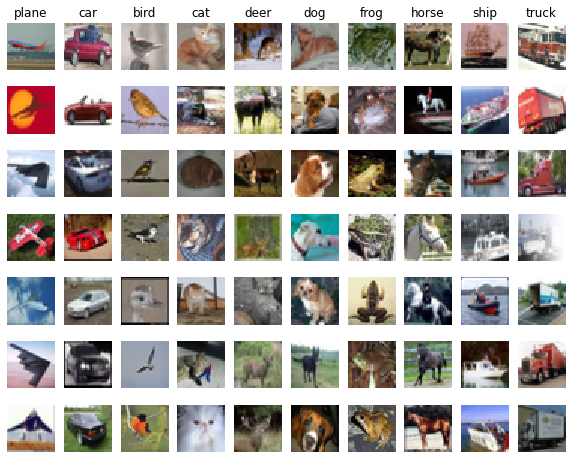

In [9]:
# 将数据集中的一些示例可视化。
#我们展示了每个类的一些训练图像示例。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [10]:
# 将数据拆分为训练集、val集和测试集。此外，我们将创建一个小的开发集作为训练数据的子集；
# 我们可以使用它进行开发，这样我们的代码运行得更快。
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 我们的验证集将是来自原始训练集的num_validation points
mask = range(num_training, num_training + num_validation)
print(mask)
X_val = X_train[mask]
y_val = y_train[mask]

# 我们的训练集将是原始训练集的第一个num_train points
mask = range(num_training)
X_train = X_train[:49000]
y_train = y_train[mask]

# 我们还将制作一个开发集，它是训练集的一个子集。
mask = np.random.choice(num_training, num_dev, replace=False)#从num_traning中随机选取出num_dev大小的数据，replace=False表示不允许重复
X_dev = X_train[mask]
y_dev = y_train[mask]

# 我们使用原始测试集的第一个num_test points作为我们的测试集。
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

range(49000, 50000)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [11]:
# 预处理：将图像数据重塑为行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# 作为健全性检查，打印出数据的形状
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


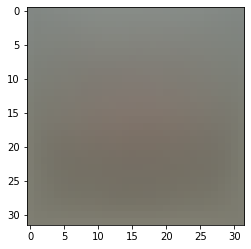

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [12]:
# 预处理：减去平均图像
# 首先：基于训练数据计算图像均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 第二：从训练和测试数据中减去平均图像
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 第三：附加1的偏差维度（即偏差技巧），使我们的SVM只需担心优化单个权重矩阵W。
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])#将两个数组按水平方向结合起来
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM 分类器

此部分的代码将全部写入`dlcv/classifiers/linear_svm.py`.

正如您所看到的，我们已经预先填充了函数“svm_loss_naive”，该函数用于循环来评估多类svm损失函数。

In [13]:
# 评估我们为您提供的损失的直接实施：
from dlcv.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.965976


从上面的函数返回的“grad”现在全部为零。推导并实现SVM成本函数的梯度，并在函数“SVM_loss_naive”内内联实现。您会发现在现有函数中交错使用新代码很有帮助。
为了检查您是否正确实现了梯度，您可以用数字估计损失函数的梯度，并将数字估计与您计算的梯度进行比较。我们为您提供了这样的代码：

In [14]:
# 一旦你实现了梯度，用下面的代码重新计算它，并用我们为你提供的函数进行梯度检查

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 用数字计算沿着几个随机选择的维度的梯度，并将它们与分析计算的梯度进行比较。
# 这些数字应该在所有维度上几乎完全匹配
from dlcv.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 打开正则化后再次进行梯度检查
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -23.794430 analytic: -23.794430, relative error: 3.964741e-12
numerical: 20.509276 analytic: 20.509276, relative error: 1.516894e-11
numerical: -8.234565 analytic: -8.234565, relative error: 4.643472e-11
numerical: -26.242060 analytic: -26.242060, relative error: 1.114482e-11
numerical: 23.791855 analytic: 23.791855, relative error: 1.308249e-11
numerical: 28.308118 analytic: 28.308118, relative error: 6.976382e-12
numerical: 9.944275 analytic: 9.944275, relative error: 2.073925e-11
numerical: 16.239874 analytic: 16.239874, relative error: 3.222417e-11
numerical: -14.806673 analytic: -14.806673, relative error: 3.715471e-13
numerical: 5.478305 analytic: 5.478305, relative error: 4.204832e-11
numerical: 8.377696 analytic: 8.377696, relative error: 4.864623e-11
numerical: 23.281210 analytic: 23.281210, relative error: 2.545750e-12
numerical: -4.511930 analytic: -4.511930, relative error: 2.008167e-11
numerical: -26.915420 analytic: -26.915420, relative error: 1.263104e-11
nume

**Inline Question 1**

偶尔梯度检查中的尺寸可能会不完全匹配。造成这种差异的原因是什么？这是令人担忧的原因吗？在一维中，梯度检查可能失败的简单示例是什么？这种情况发生的频率会对差距产生怎样的影响
*提示：严格来说，SVM损失函数是不可微的*

$\color{blue}{\textit Your Answer:}$ *偶尔的梯度检查中的尺寸可能会不完全匹配，造成这种差异的原因我认为有以下三种：1.数值不稳定，浮点数运算存在精度限制，导致梯度计算和数值方法存在差异；2.数值近似：梯度通过数值近似计算，通过微小变化计算损失函数的差异。如果选择的值太小或太大，都会导致数值稳定性问题；3.数值不稳定的梯度函数：某些损失函数在某些点上可能不可微或不光滑。   尺寸不完全匹配可能是数值问题，通常情况下不算令人担忧的问题。如果差异非常大，表明梯度计算方法存在问题或者损失函数可能存在数值稳定性问题。 Pytroch框架提供自动微分的方法会大大减少梯度检查问题的发生。   简单示例：f(x) = |x|，在 x=0 处梯度是不可微的，因为它有一个鞍点。在这种情况下，使用传统的数值方法来计算梯度可能会失败。 对于大多数光滑的损失函数，数值稳定性问题可能不太常见，但对于不可微或不稳定的损失函数，这些问题可能更加普遍。关键是要警惕梯度检查问题，确保所使用的数值方法是正确的，并尽量使用自动微分来减少这类问题的出现。*

In [16]:
# 接下来实现函数svm_loss_vectorized；目前只计算损失；我们稍后将实现梯度。
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dlcv.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


# 损失应该匹配，但矢量化的实现应该更快。
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.965976e+00 computed in 0.201877s
Vectorized loss: 8.965976e+00 computed in 0.003994s
difference: -0.000000


In [17]:
# 完成svm_loss_vectorized的实现，并以矢量化的方式计算损失函数的梯度。

# 直接的实现和向量化的实现应该匹配，但向量化的版本仍然应该快得多。
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# 损失是一个数值，因此很容易比较两种实现计算的值。
# 另一方面，梯度是一个矩阵，因此我们使用Frobenius范数来比较它们。
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.203691s
Vectorized loss and gradient: computed in 0.003999s
difference: 0.000000


### 随机梯度下降

我们现在有了的矢量化的和有效的损失表达式，该梯度和我们的梯度与梯度的数值匹配。因此，我们准备进行随机梯度下降，以最大限度地减少损失。这部分的代码将写在`dlcv/classifiers/lineral_classifier.py`中。

In [18]:
# 在文件 linear_classifier.py 的函数 LinearClassifier.train（）中实现SGD，然后用下面的代码运行它。
from dlcv.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.257654
iteration 100 / 1500: loss 473.451393
iteration 200 / 1500: loss 286.530186
iteration 300 / 1500: loss 174.727463
iteration 400 / 1500: loss 106.450850
iteration 500 / 1500: loss 66.892007
iteration 600 / 1500: loss 43.209175
iteration 700 / 1500: loss 27.676964
iteration 800 / 1500: loss 18.856893
iteration 900 / 1500: loss 13.798684
iteration 1000 / 1500: loss 10.275089
iteration 1100 / 1500: loss 8.586301
iteration 1200 / 1500: loss 7.116581
iteration 1300 / 1500: loss 6.668896
iteration 1400 / 1500: loss 5.987359
That took 7.254456s


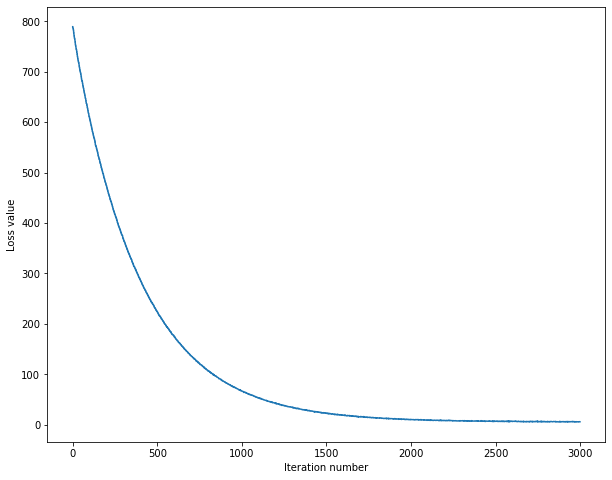

In [19]:
# 一个有用的调试策略是将损失绘制为迭代次数的函数:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
# 编写LinearSVM.predict函数，并评估训练和验证集
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.379102
validation accuracy: 0.385000


In [29]:
# 使用验证集来调整超参数（正则化强度和学习率）。
# 你应该在不同的学习率和正则化强度范围内进行实验；
# 如果你小心的话，你应该能够在验证集上获得大约0.39（＞0.385）的分类准确度。

# 注意：在超参数搜索过程中，您可能会看到运行时/溢出警告。
# 这可能是由极值引起的，并不是一个错误。

# 结果是字典将元组（learning_rate，regularizationstrength）映射到
# 元组的形式(training_accuracy, validation_accuracy)。
# 准确度只是正确分类的数据点的分数。
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:
# 编写代码，通过调整验证集来选择最佳超参数。
# 对于超参数的每个组合，在训练集上训练线性SVM，计算其在训练集和验证集上的准确性，
# 并将这些数字存储在结果字典中。此外，将最佳验证精度存储在best_val中，
# 并将实现此精度的LinearSVM对象存储在best_svm中。
# 提示：在开发验证代码时，应该为num_iters使用一个小值，这样SVM就不会花太多时间进行训练；
# 一旦您确信您的验证代码有效，您就应该重新运行具有较大numiters值的验证代码。
################################################################################

# 作为参考提供。您可能想要更改这些超参数
learning_rates = [2e-7, 0.75e-7,1.5e-7, 1.25e-7, 0.75e-7]
regularization_strengths = [3e4, 3.25e4, 3.5e4, 3.75e4, 4e4,4.25e4, 4.5e4,4.75e4, 5e4]

# *****     代码的开头（不要删除/修改此行）        *****

def train_and_evaluate_svm(X_train, y_train, X_val, y_val, lr, reg):
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)
    
    y_train_pred = svm.predict(X_train)
    y_train_accuracy = np.mean(y_train == y_train_pred)
    
    y_val_pred = svm.predict(X_val)
    y_val_accuracy = np.mean(y_val == y_val_pred)
    
    return y_train_accuracy, y_val_accuracy, svm

results = {}
best_val = -1

for lr in learning_rates:
    for reg in regularization_strengths:
        y_train_accuracy, y_val_accuracy, svm = train_and_evaluate_svm(X_train, y_train, X_val, y_val, lr, reg)
        results[(lr, reg)] = (y_train_accuracy, y_val_accuracy)
        
        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_svm = svm

# *****     代码的结尾（不要删除/修改此行）        *****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 7.500000e-08 reg 3.000000e+04 train accuracy: 0.376980 val accuracy: 0.394000
lr 7.500000e-08 reg 3.250000e+04 train accuracy: 0.376449 val accuracy: 0.390000
lr 7.500000e-08 reg 3.500000e+04 train accuracy: 0.374755 val accuracy: 0.381000
lr 7.500000e-08 reg 3.750000e+04 train accuracy: 0.376000 val accuracy: 0.388000
lr 7.500000e-08 reg 4.000000e+04 train accuracy: 0.372510 val accuracy: 0.388000
lr 7.500000e-08 reg 4.250000e+04 train accuracy: 0.376939 val accuracy: 0.386000
lr 7.500000e-08 reg 4.500000e+04 train accuracy: 0.373918 val accuracy: 0.392000
lr 7.500000e-08 reg 4.750000e+04 train accuracy: 0.369714 val accuracy: 0.377000
lr 7.500000e-08 reg 5.000000e+04 train accuracy: 0.373286 val accuracy: 0.376000
lr 1.250000e-07 reg 3.000000e+04 train accuracy: 0.377510 val accuracy: 0.376000
lr 1.250000e-07 reg 3.250000e+04 train accuracy: 0.381816 val accuracy: 0.374000
lr 1.250000e-07 reg 3.500000e+04 train accuracy: 0.374857 val accuracy: 0.374000
lr 1.250000e-07 reg 3.750000

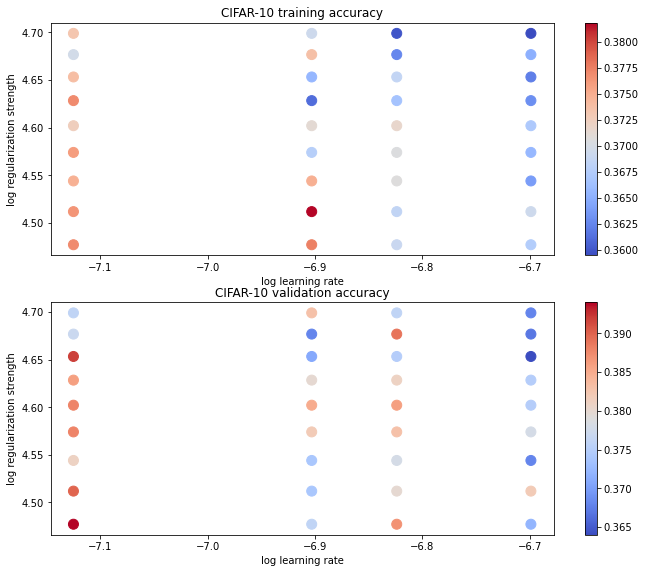

In [30]:
# 可视化交叉验证结果
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [31]:
# 评估测试集上的最佳svm
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373000


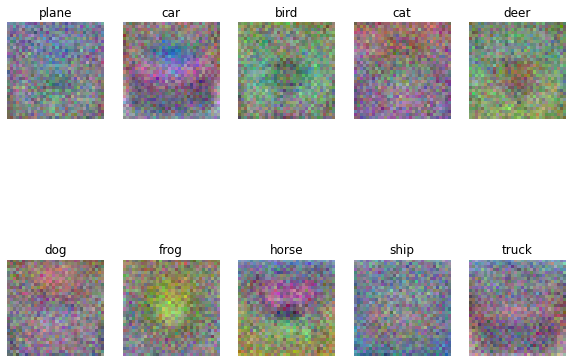

In [32]:
# 将每个类的学习权重可视化。

w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

描述可视化的SVM权重是什么样子的，并简要解释它们为什么看起来像这样。

$\color{blue}{\textit Your Answer:}$ *不同的权重矩阵可视化后呈现不同的视觉效果，可以反映出模型对不同类别标签图片的特征学习。原因在于同一类别的图片具有大致相同的数字特征，跟权重矩阵相互匹配。*  